# Data Drift Detection

The current notebook implements data drift detection on a dataset having motion sense data of a smart watch. The reference series is the attitude.roll value of jogging movement of subject 2. The test series is an artifically drifted dataset where we have added drift by adding the jogging movement values of subject 11. The Interval between each window is exponential distributed with lambda = 2000 and size of each drift window is normally distributed with mean = 1000 and std = 50

## Code Implementation

In [25]:
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from evidently.calculations.stattests import jensenshannon_stat_test
from evidently.calculations.stattests import kl_div_stat_test
from evidently.calculations.stattests import ks_stat_test
from evidently.calculations.stattests import psi_stat_test
from evidently.calculations.stattests import wasserstein_stat_test
from sklearn.metrics import confusion_matrix
import multiprocess

from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def return_drift(ref: pd.Series, curr: pd.Series):
    """
    Summary: Returns the statistical difference between population of ref and curr

    Input: 
    ref:- Reference serie based on historical data
    curr:- Test series to be compared with

    Output: Series with the stats scores of different tests
    """

    report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
    for i, (stattest, threshold) in enumerate(
        zip([ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
            [0.05, 0.1, 0.1, 0.1, 0.1])):
        report.loc[i, 'stat_test'] = stattest.display_name
        report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = \
        stattest.func(ref, curr, 'num', threshold)
    return report['drift_score']

def add_new_drift(curr_new: pd.Series, drift_size: float, start_index: int,
                  stop_index:int,drift_mode :str= "0-shift"):
    
    """
    Summary:- Adds drift by displacing the values by a certain scale of the standard deviation
    of the data

    Input: 
    curr_new :- Series where the drift has to be introduced
    drift_size :- Scale of drift to be added
    start_index :- Start index in the series where drift has to be added
    stop_index :- End index in the series where drift has to be added
    drift_mode :- Mode of drift addition - i.e max 1 std, 2 std etc

    Output:
    Series with the drift added
    """

    drift_interval = (stop_index - start_index) 
    curr_df = curr_new.copy()
    
    col_names  = list(curr_df.columns)
    
    for curr_col in col_names:
        
        curr = curr_df[curr_col]
        if drift_mode=="0-shift":
            ## Shifting the data with a scale of norm(0) * std(data)
            drift_curr = (np.random.normal(0,1,drift_interval))*drift_size*np.std(curr)
        elif drift_mode == '2-shift':
            ## Shifting the data with a scale of norm(2) * std(data)
            drift_curr = (np.random.normal(2,1,drift_interval))*drift_size*np.std(curr)
        else:
            ## Shifting the data with a scale of norm(1) * std(data)
            drift_curr = (np.random.normal(1,1,drift_interval))*drift_size*np.std(curr)
    
        curr[start_index:stop_index] = curr[start_index:stop_index] + drift_curr
        curr_df[curr_col] = curr
    
    return curr_df


def create_test_set(df_jog1: pd.DataFrame,size_limit = 100000) -> tuple:

    """
    Summary: Creates a test dataset by adding synthetic drift

    Input:
    df_jog1 :- Dataframe on to which drift is added

    Output:
    Tuple of the following
    df_jog_shifted :- Series with drift added to it
    df_jog :- Input series to act as reference
    bin_indi :- Series with binary indicators of drift (1) or not
    """

    df_jog = pd.DataFrame()

    ## Replicating the dataframe num_iter times
    df_size = df_jog1.shape[0]

    if(df_size> size_limit):
        df_jog = df_jog1[:size_limit].copy()
    else:
        while(df_size < size_limit):
            df_jog = pd.concat([df_jog,df_jog1])
            df_size = df_jog.shape[0]

    df_jog.reset_index(drop=True,inplace=True)

    ## Generating the drift intervals

    start_index = 0
    stop_index = 0
    N_max = df_jog.shape[0] 
    interval_num = 1 ## Counter on number of intervals where drift was added

    """
    Parameters:

    interval_lambda :- The interval between each drift window is separated is
    exponential distributed. The variable indicates the lambda value of the 
    distribution

    drift_size :- Scale of drift to be added

    size_mean :- The length of each drift window is normally distributed. 
    This variable indicates the mean of the this distribution

    size_std :- The length of each drift window is normally distributed. 
    This variable indicates the std of the this distribution
    """

    interval_lambda = 2000 
    drift_size = 0.9
    size_mean = 1000
    size_std = 50

    curr_interval = int(np.random.exponential(scale = interval_lambda,size=1))
    curr_size = int(np.random.normal(size_mean,size_std,1))

    start_index = start_index + curr_interval ## Start index of next drift window
    stop_index = start_index + curr_size ## Stop index of next drift window

    ## Adding zeroes to indicate no drift 
    bin_indi = np.zeros(curr_interval) 
    ## Adding ones to indicate drift occured for a window of curr size
    bin_indi = np.concatenate([bin_indi,np.ones(curr_size)]) 

    ## Adding drift to the series based on start and end index
    df_jog_shifted = add_new_drift( df_jog,drift_size=drift_size,start_index=start_index,
                                stop_index=stop_index,drift_mode="2-shift")

    ## Obtaining the next set of window
    curr_interval = int(np.random.exponential(scale = interval_lambda,size=1))
    curr_size = int(np.random.normal(size_mean,size_std,1))


    start_index = stop_index + curr_interval
    stop_index = start_index + curr_size

    while(stop_index<=N_max): ## Iterating till we reach the end of series

        ## Adding zeroes to indicate no drift from end of curr window till start of next window
        bin_indi = np.concatenate([bin_indi,np.zeros(curr_interval)])
        ##Adding ones to indicate drift occured for a window of curr size
        bin_indi = np.concatenate([bin_indi,np.ones(curr_size)])

        interval_num+=1
        df_jog_shifted = add_new_drift(df_jog_shifted,drift_size=drift_size,start_index=start_index,
                                    stop_index=stop_index,drift_mode="0-shift")

        ## Updating the start and end index with new values
        curr_interval = int(np.random.exponential(scale = interval_lambda,size=1))
        curr_size = int(np.random.normal(size_mean,size_std,1))

        start_index = stop_index + curr_interval
        stop_index = start_index + curr_size

    ## To offset the end of the indicator values with zeros to indicate no drift
    offset_val = (df_jog_shifted.shape[0]) - len(bin_indi)
    bin_indi = np.concatenate([bin_indi,np.zeros(offset_val)])

    return (df_jog_shifted,df_jog,bin_indi)


def return_optimum_window_size(main_series: pd.Series) -> int:

    """
    Summary: Function to find the optimum window size for implementing data drift detection.
    A Bayesian optimizer is used to find the window size with the maximum accuracy by adding random
    drift in the reference data and calculating accuracy with respect to the data.

    Input: 
    main_series:- Reference series to be tested for optimum window size

    Output:
    Window size
    """

    size_limit = 100000 ## Maximum size of the test series
    main_df = pd.DataFrame(main_series)
    
    ## Creating the synthetic series for finding the optimum window size 
    (drifted_df,ref_df,bin_indi) = create_test_set(main_df,size_limit)
    
    curr_test  = drifted_df.iloc[:,0] ## Test data
    ref_total  = ref_df.iloc[:,0] ## Reference data to detect drift
    curr_indi  = pd.DataFrame({"indi":bin_indi}).iloc[:,0] ## Binary indicators on drift 

    curr_test = curr_test.reset_index(drop=True) 


    def check_drift_accuracy(N_arr: float) -> float:

        """
        Summary: Function to return the accuracy on the drift data when window size of N_arr is used
        
        Input: Current window size

        Output:
        Accuracy measure
        """
    
        N = int(N_arr*100) # Since window size must be an integer

        curr_buff = curr_test[:N]
        chunk_size= 200  ## Current chunk size

        ## To feed the data in chunks
        curr_start = N
        curr_end = N+chunk_size

        end_data = size_limit 
        curr_t = N

        result_pd = pd.DataFrame() ## Dataframe where the results of the stats tests will be stored
        fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
        test_names = [each_test.display_name for each_test in fun_name]
        result_pd['Test'] = test_names

        ## To obtain the reference series
        curr_ref = ref_total[:]

        ## Iterating on the different chunks
        while(curr_end <= end_data ):

            curr_res = return_drift(curr_ref, curr_buff) ## Getting the stats scores
            result_pd['t=' + str(curr_t)] = curr_res

            ## Importing the new chunk
            curr_start = curr_start + chunk_size 
            curr_end = curr_end + chunk_size
            curr_chunk = curr_test[curr_start:curr_end]

            curr_buff = curr_buff[chunk_size:]
            curr_buff = pd.concat([curr_buff,curr_chunk])
            curr_t = curr_t + chunk_size

        result_pd = result_pd.T 

        result_pd.columns = result_pd.iloc[0]
        result_pd.drop(result_pd.index[0],inplace=True)
        result_pd.reset_index(drop=False,inplace=True)

        result_pd_2  = result_pd.copy()
        for each_test in test_names:
            result_pd_2[each_test] = result_pd_2[each_test].astype('float') ## Final result dataframe

        index_col = np.arange(start=N,stop=end_data,step=chunk_size)

        indi_column = curr_indi[index_col].reset_index(drop=True) ## Getting the correct indices

        result_pd_2['Correct_mark'] = indi_column 

        ## Set thresholds for determing the drift accuracy for different metrics
        PSI_threshold = 3
        JS_threshhold = 0.5
        KL_Div_threshold = 2

        ## Checking whether drift occured based on each statistical measure
        result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
        result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
        result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

        ## Obtaining the accuracy measures
        tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
        summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
        tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
        summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
        tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
        summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

        summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
        summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
        summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

        return_val = summary_pd['Accuracy'] ## The accuracy is chosen as the return metric

        ## We only report the accuracy only if drift is reported for atleast one point
        tp_count = int(sum(summary_pd['TP'])) 
        if tp_count==0:
            return 0

        return int(sum(return_val*100))

    ##########################################################################
    ##   Optimization implementation using the above function               ##
    ##########################################################################
    

    start = time.time()

    global_res = []

    def bayesian_optimiser(start_val: int, end_val: int) -> dict:

        """
        Inputs:
        start_val :- lower bound of search space
        end_val :- upper bound of search space

        Summary: Obtains the window size producing the maximum drift accuracy 
        in the provided search space

        Outputs:
        Dictionary with optimum window and its accuracy
        """

        pbounds = {'N_arr':(start_val,end_val)}
        bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)

        optimizer = BayesianOptimization(
            f=check_drift_accuracy,
            pbounds=pbounds, ## bounds for search
            verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=5, ## random state
            bounds_transformer= bounds_transformer, ## inbuilt function which shrinks the search space
            allow_duplicate_points=True ## allowing same value to be repeated
        )

        optimizer.maximize(init_points=5,n_iter=50) ## n_iter = no of iterations
        res_dict = {}
        res_dict['Window'] = int(optimizer.max['params']['N_arr']*100)
        res_dict['Accuracy'] = optimizer.max['target']

        return res_dict
    
    ## Ranges of window sizes
    para_list = [(1,20),(21,40),(41,60),(61,80),(81,100)]

    ## Implementing multiprocessing with 5 processors
    with multiprocess.Pool(5) as p:
        global_res += p.starmap(bayesian_optimiser,para_list)

    stop = time.time()
    
    total_time = (stop - start)/60
    print(f'Time taken for optimziation is {total_time}') ## Time taken
    
    
    ### Finding the best window size out of all bounds   
    curr_max = -1
    curr_window = 0
    
    for each_window in global_res:
        if(each_window['Accuracy']>curr_max):
            curr_window = each_window['Window']
            curr_max = each_window['Accuracy']
        
    print(f'The optimum window size is {curr_window} and accuracy is {curr_max}')
    
    return curr_window
    
    

In [20]:

import pandas as pd
import numpy as np

from evidently.calculations.stattests import jensenshannon_stat_test
from evidently.calculations.stattests import kl_div_stat_test
from evidently.calculations.stattests import ks_stat_test
from evidently.calculations.stattests import psi_stat_test
from evidently.calculations.stattests import wasserstein_stat_test

def return_drift(ref: pd.Series, curr: pd.Series):
    """
    Summary: Returns the statistical difference between population of ref and curr

    Input: 
    ref:- Reference serie based on historical data
    curr:- Test series to be compared with

    Output: Series with the stats scores of different tests
    """

    report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
    for i, (stattest, threshold) in enumerate(
        zip([ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
            [0.05, 0.1, 0.1, 0.1, 0.1])):
        report.loc[i, 'stat_test'] = stattest.display_name
        report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = \
        stattest.func(ref, curr, 'num', threshold)
    return report['drift_score']


def return_drift_indicator(curr_ref: pd.Series, curr_buff: pd.Series, return_dataframe=False):
        
    """
    Summary: Checks for drift between reference and test series

    Input:
    curr_ref :- The reference series
    curr_buff :- Current test series
    return_dataframe :- Boolean variable indicating whether to return the results dataframe

    Output:
    curr_result :- Indicator denoting whether there is a drift or not
    curr_result :- Results dataframe with stats test values and individual indicators
    """
    
    fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
    test_names = [each_test.display_name for each_test in fun_name]

    ## Thersholds for each test
    PSI_threshold = 3
    JS_threshhold = 0.5
    KL_Div_threshold = 2
    overall_threshold = 0.5

    curr_t = 1

    ## Result dataframe with stats test values
    curr_res = return_drift(curr_ref, curr_buff)

    ## Curr_value
    curr_check = pd.DataFrame()
    curr_check['Test'] = test_names
    curr_check['t=' + str(curr_t)] = curr_res

    curr_check = curr_check.T
    curr_check.columns = curr_check.iloc[0]
    curr_check.drop(curr_check.index[0],inplace=True)
    curr_check.reset_index(drop=False,inplace=True)

    ## Checking if there is a drift based on individual and test values 
    curr_check['PSI_drift'] = np.where(curr_check['PSI']>PSI_threshold,1,0)
    curr_check['JS_drift'] = np.where(curr_check['Jensen-Shannon distance']>JS_threshhold,1,0)
    curr_check['KL_drift'] = np.where(curr_check['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

    ## Considering weighted results of tests and getting the overall result
    curr_check['Overall_drift'] = np.where(((0.4*curr_check['PSI_drift']+
                                              0.4*curr_check['JS_drift']+
                                              0.2*curr_check['KL_drift']))>overall_threshold,1,0)

    curr_result = curr_check['Overall_drift'][0]

    if return_dataframe:
        return (curr_result,curr_check)
    else:
        return curr_result


The code has been slightly modified to account for running in a jupyter notebook. But the results will be the same.

In [22]:
import time
import argparse
import csv
import sys
import yaml
import pandas as pd


ref_total = pd.read_csv('/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Datasets/Motion_Sense/A_DeviceMotion_data/jog_9/sub_2.csv')
ref_total.drop("Unnamed: 0",axis=1,inplace=True)
ref_total = ref_total['attitude.roll']

## Obtaining the optimum window size
max_window = return_optimum_window_size(ref_total)

chunk_size = 1 ## Chunk size with which data is fed in
## Maximum consecutive data points after which drift is alarmed
max_threshold = 40
curr_threshold_check = 0 ## Counter for checking consecutive points

result_pd = pd.DataFrame()
return_dataframe = True ## Boolean to decide if results need to be returned (For debug only)

curr_buff = pd.Series() ## Dataframe to hold the test values

## Helper function to simulate streaming using csv values
def stream_csv_data(filename):
    """
    Summary: Function to simulate streaming data

    Input:
    filename: Name of csv file
    """
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)  # Read the header row
        for row in reader:
            yield dict(zip(headers, row))
            time.sleep(0.5)  # Simulate a delay of 0.5 second between each row

## Test data
folder_location = '/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Datasets/Motion_Sense/Test_datasets/'
csv_filename = folder_location + 'Subject_2_11_distributed_lambda=2000_size=1000_50.csv'

curr_t = max_window
for data_row in stream_csv_data(csv_filename):
    curr_value = float(data_row['attitude.roll']) ## Reading the new value

    ## Checking if curr buffer size is less than window
    ## If yes, we fill the buffer else we test for drift
    if len(curr_buff) < max_window:
        curr_buff = pd.concat([curr_buff,pd.Series(curr_value)])
    else:
        if return_dataframe:
            curr_result,curr_res_dataframe = \
            return_drift_indicator(curr_buff,ref_total,return_dataframe)    
        else:
            curr_result = \
                return_drift_indicator(curr_buff,ref_total,return_dataframe)

        if curr_result==1:
            curr_threshold_check+=1 ## Increasing the counter if we detect drift
        else:
            curr_threshold_check = 0

        if curr_threshold_check > max_threshold:
            print('Drift Detected')
            break

        ## Updating the buffer
        curr_buff = curr_buff[chunk_size:]
        curr_buff = pd.concat([curr_buff,pd.Series(curr_value)])

        if return_dataframe:
            curr_res_dataframe['index'] = 't=' + str(curr_t)
            curr_t += 1
            result_pd = pd.concat([result_pd,curr_res_dataframe])


Time taken for optimziation is 30.443212497234345
The optimum window size is 402 and accuracy is 223.0


/var/folders/hn/4swgrrzj36vd9rq1mqmr39j80000gn/T/ipykernel_849/2828195214.py:36: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  curr_buff = pd.Series() ## Dataframe to hold the test values


Drift Detected


## Results

Text(0.5, 1.0, 'Reference Data')

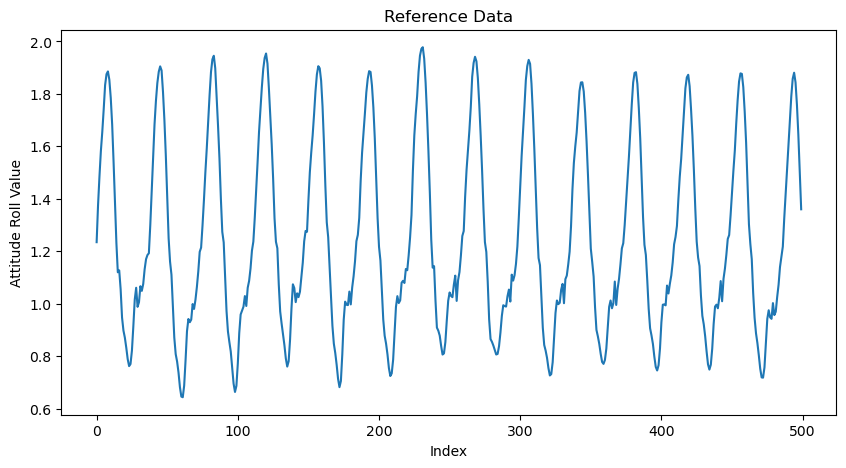

In [34]:
## Plotting the reference series

fig,ax = plt.subplots(figsize=(10,5))
plt.plot(ref_total[:500])
plt.xlabel('Index')
plt.ylabel('Attitude Roll Value')
plt.title('Reference Data')

Text(0.5, 1.0, 'Test Data')

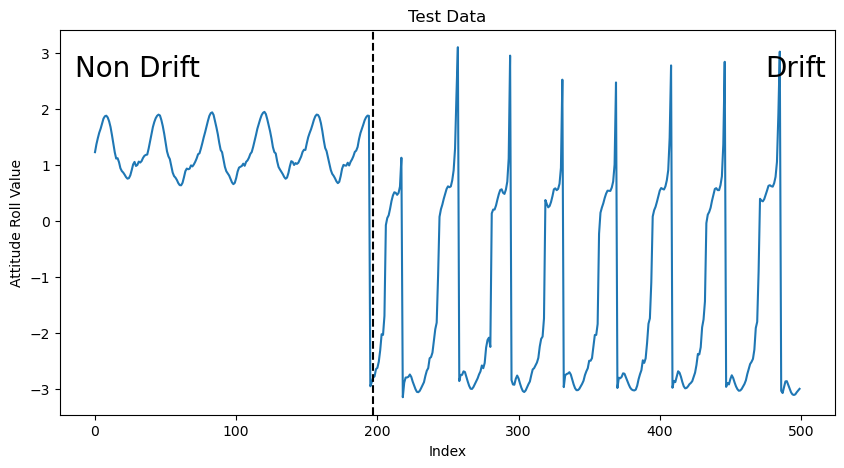

In [35]:
## Plotting the Test series

test_data = pd.read_csv(csv_filename)
test_data = test_data['attitude.roll']

fig,ax = plt.subplots(figsize=(10,5))
plt.plot(test_data[:500])
plt.text(0.1, 0.9, 'Non Drift', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
plt.text(0.95, 0.9, 'Drift', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
plt.axvline(x = 197, color = 'black', label = 'Drift',ls='--')
plt.xlabel('Index')
plt.ylabel('Attitude Roll Value')
plt.title('Test Data')

In [23]:
result_pd

Test,index,K-S p_value,PSI,Kullback-Leibler divergence,Jensen-Shannon distance,Wasserstein distance (normed),PSI_drift,JS_drift,KL_drift,Overall_drift
0,t=402,0.0,3.04142,2.341328,0.439412,0.886033,1,0,1,1
0,t=403,0.0,3.046202,2.343748,0.440079,0.88739,1,0,1,1
0,t=404,0.0,3.056685,2.347959,0.441431,0.889097,1,0,1,1
0,t=405,0.0,3.067468,2.352265,0.442812,0.89097,1,0,1,1
0,t=406,0.0,3.078561,2.356666,0.444221,0.89288,1,0,1,1
0,t=407,0.0,3.08497,2.358602,0.444973,0.894612,1,0,1,1
0,t=408,0.0,3.08497,2.358602,0.444973,0.895249,1,0,1,1
0,t=409,0.0,3.067392,2.354825,0.44336,0.892373,1,0,1,1
0,t=410,0.0,3.091452,2.374922,0.444694,0.897766,1,0,1,1
0,t=411,0.0,3.115759,2.395132,0.446053,0.903271,1,0,1,1


The maximum threshold is kept as 40. Hence the algorithm reported drift after detecting 40 data points as drifted after t= 402. We started from t = 402 since the window size was 402.

In [54]:
def plot_drift_graph(df_plot,sheet_name,x_diff):
    df_plot.index = df_plot['index']                      
    fix,ax = plt.subplots(figsize=(12,9))
    plt.plot(df_plot['PSI'],label='PSI')
    plt.plot(df_plot['Kullback-Leibler divergence'],label='Kullback-Leibler divergence')
    plt.plot(df_plot['Jensen-Shannon distance'],label='Jensen-Shannon distance')
    plt.xticks(df_plot.index[::x_diff],df_plot['index'][::x_diff],rotation=90)
    plt.yticks(range(15),range(15))
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Parameter Value',fontsize=15)
    plt.title(sheet_name,fontsize=15)
    plt.grid()
    plt.legend()

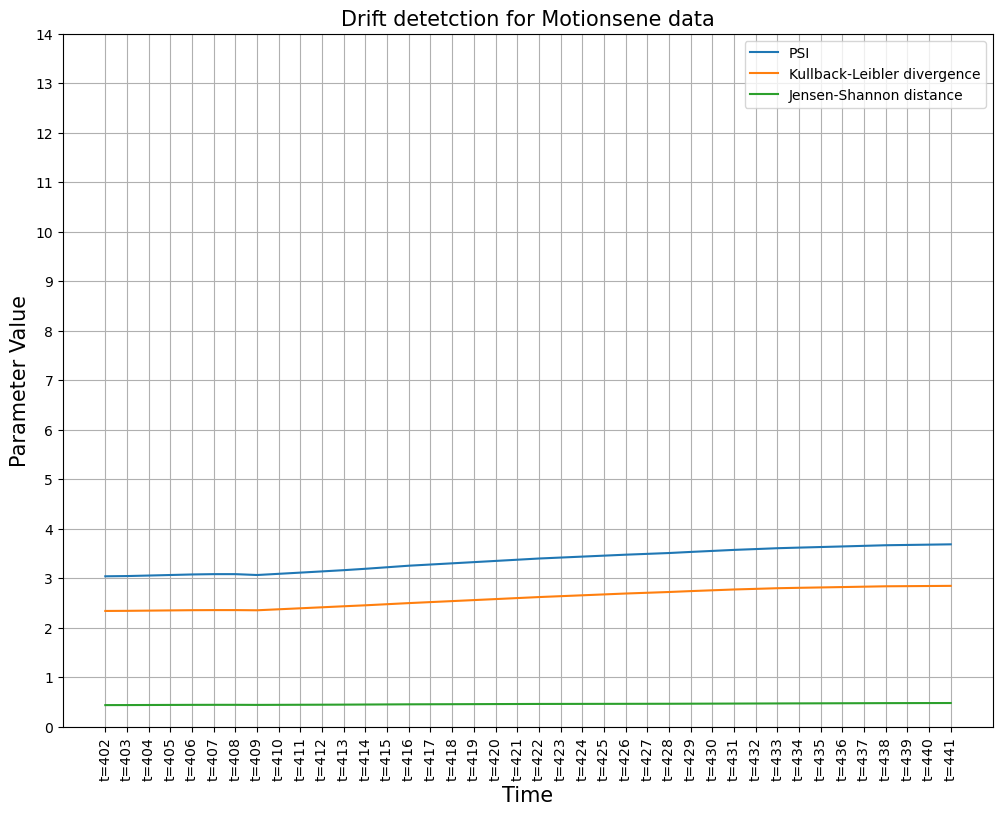

In [55]:
plot_drift_graph(result_pd,'Drift detetction for Motionsene data',1)

The above graph showcases the statistical values obtained over time. We can see that at all times, the values were above the threshold.